# Cross Entropy Method for Sampling in Risk-Averse RL

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gym
import GuardedMaze
import GuardedMazeLab as GML
import Agents
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

### The Guarded Maze benchmark

A sample episode of a random agent:

Return: -32


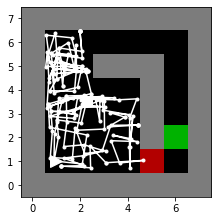

In [2]:
# Make sure the environment is registered
if 'GuardedMazeEnv-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['GuardedMazeEnv-v0']
gym.envs.registration.register(id='GuardedMazeEnv-v0', entry_point='GuardedMaze:GuardedMaze')

# Load env
env = gym.make('GuardedMazeEnv-v0')
env.reset(init_state=(1,1))

# Run episode (with random actions)
done = False
while not done:
    obs, r, done, info = env.step(env.action_space.sample())

# Summarize episode
print('Return:', info['r'])
env._show_state()
env.close()

### CE for risk-averse RL on the Guarded Maze

Constant guard-cost, random guard-presence: the guard-presence probability $p$ is drawn every episode from a $Beta$ distribution with $mean=5\%$; then every step in the danger zone the agent is spotted with probability $p$.
CVaR optimization in this case is with respect to the randomness in the value of $p$.

Training 5/5 remaining agents...
Training 5 agents...
Waiting for trainings...
Waiting for processes...
Done.	(4911s)
Waiting for tests...
Waiting for processes...
Done.	(136s)
PG:	mean=5.4	CVaR10=-34.4	CVaR05=-55.4
GCVaR:	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
CE_GCVaR:	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
SGCVaR:	mean=-32.0	CVaR10=-32.0	CVaR05=-32.0
CE_SGCVaR:	mean=2.0	CVaR10=-3.6	CVaR05=-4.8
Wall time: 1h 25min 36s


,agent,group,episode,ag_updates,ag_hash,ag_temperature,guard_prob,guard_cost,s0_x,s0_y,path,log_prob,ret_loss,score,opt_selected,ce_selected,weight
0,PG,train,0,0,0x4e1e7d83646765cf,1,1.785993e-03,4.0,1.357227,2.678971,-1.0,-196.767578,0.206815,-16.0,1.0,NaN,NaN
1,PG,train,1,0,0x4e1e7d83646765cf,1,2.676383e-05,4.0,2.453681,1.653739,-1.0,-221.729248,-44.625282,-32.0,1.0,NaN,NaN
2,PG,train,2,0,0x4e1e7d83646765cf,1,1.836144e-07,4.0,3.592009,1.448401,-1.0,-224.345795,-45.937706,-32.0,1.0,NaN,NaN
3,PG,train,3,0,0x4e1e7d83646765cf,1,4.345720e-01,4.0,1.859121,1.211977,-1.0,-47.519798,-101.029144,-80.0,1.0,NaN,NaN
4,PG,train,4,0,0x4e1e7d83646765cf,1,2.208204e-05,4.0,1.083936,1.989580,-1.0,-144.837448,-5.375723,-16.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305295,CE_SGCVaR,test,1055,150,0x15d83072aa3c5cb,0,2.242145e-02,4.0,0.812997,1.496390,1.0,-0.295406,0.151900,-3.0,NaN,NaN,NaN
305296,CE_SGCVaR,test,1056,150,0x15d83072aa3c5cb,0,2.670466e-01,4.0,3.578661,3.242188,1.0,-0.036319,0.200924,0.0,NaN,NaN,NaN
305297,CE_SGCVaR,test,1057,150,0x15d83072aa3c5cb,0,4.161777e-12,4.0,1.097582,2.618117,1.0,-0.090902,-0.086172,-1.0,NaN,NaN,NaN
305298,CE_SGCVaR,test,1058,150,0x15d83072aa3c5cb,0,7.606563e-04,4.0,2.192164,1.535172,1.0,-0.209847,-0.204680,2.0,NaN,NaN,NaN


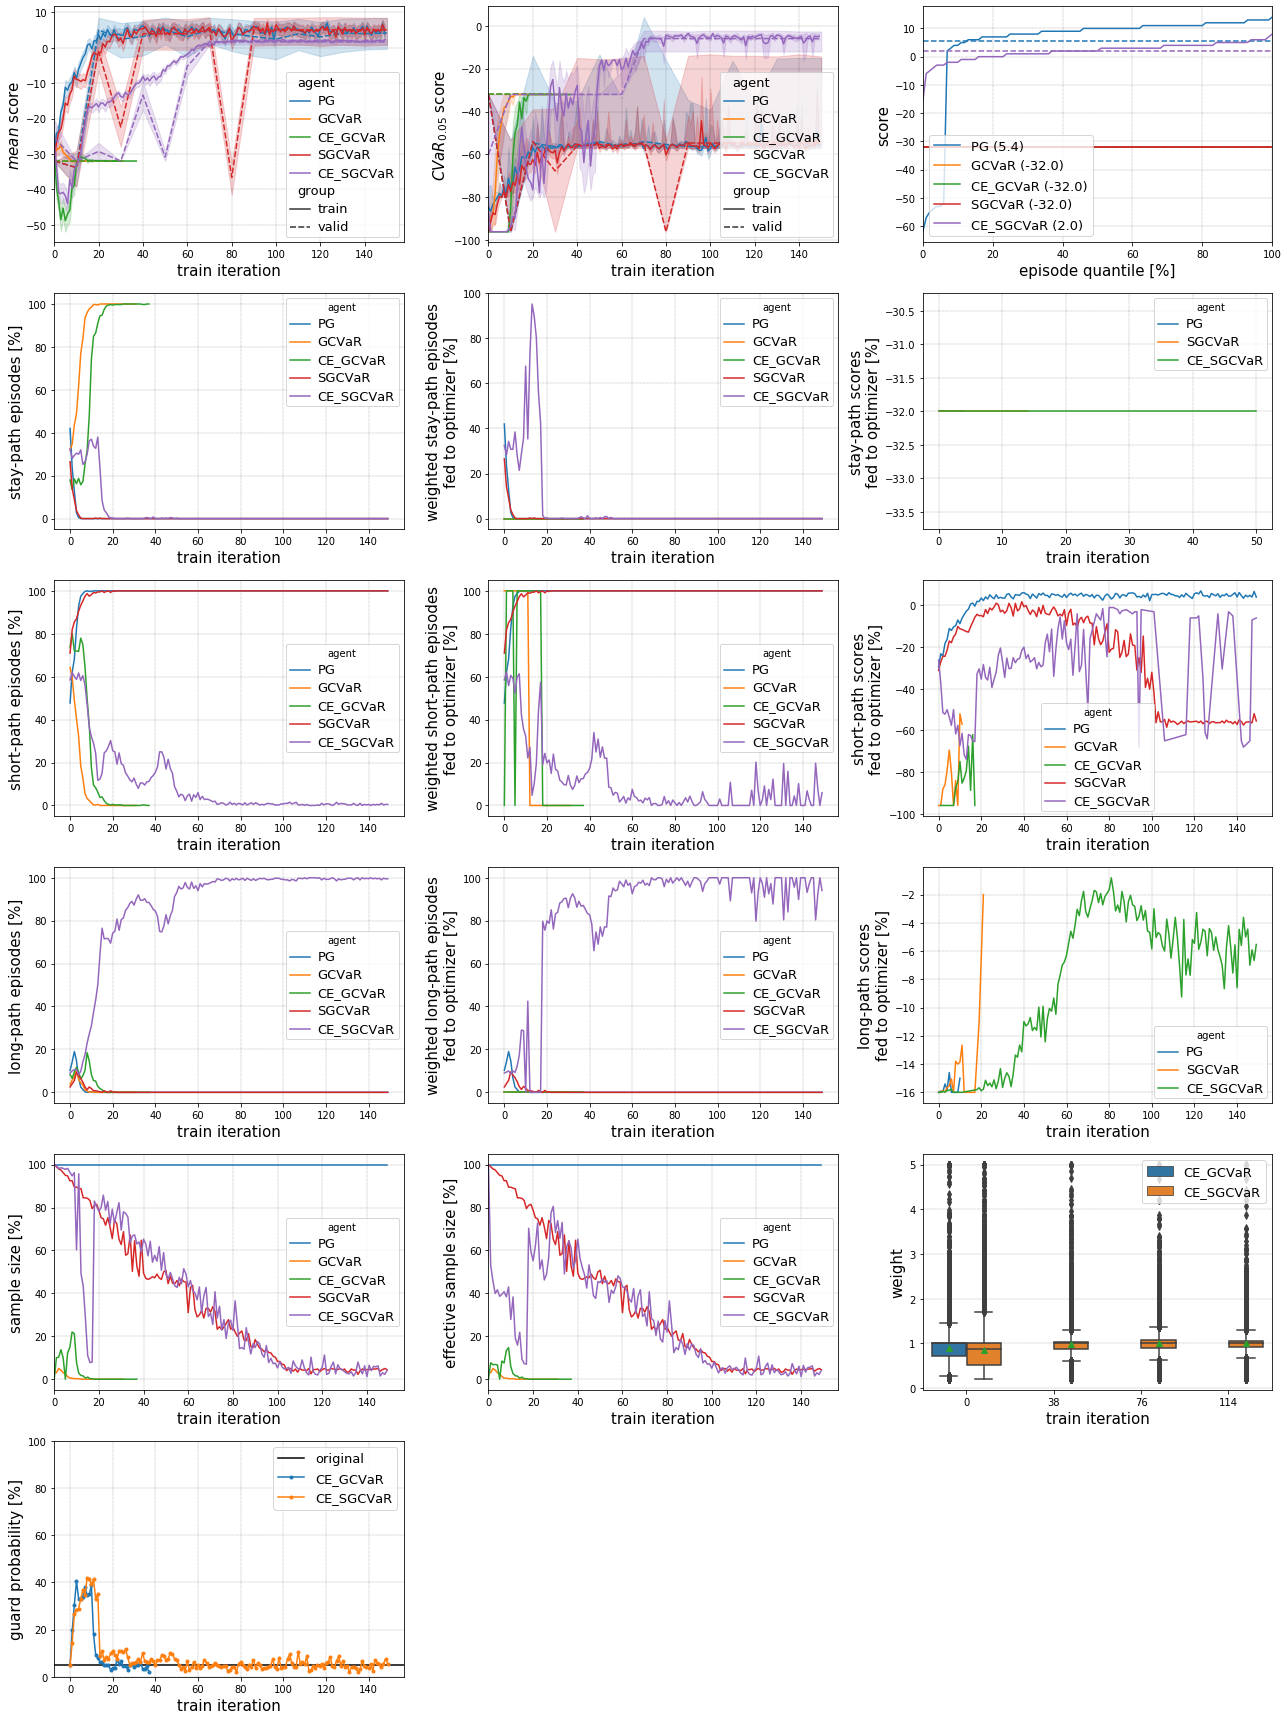

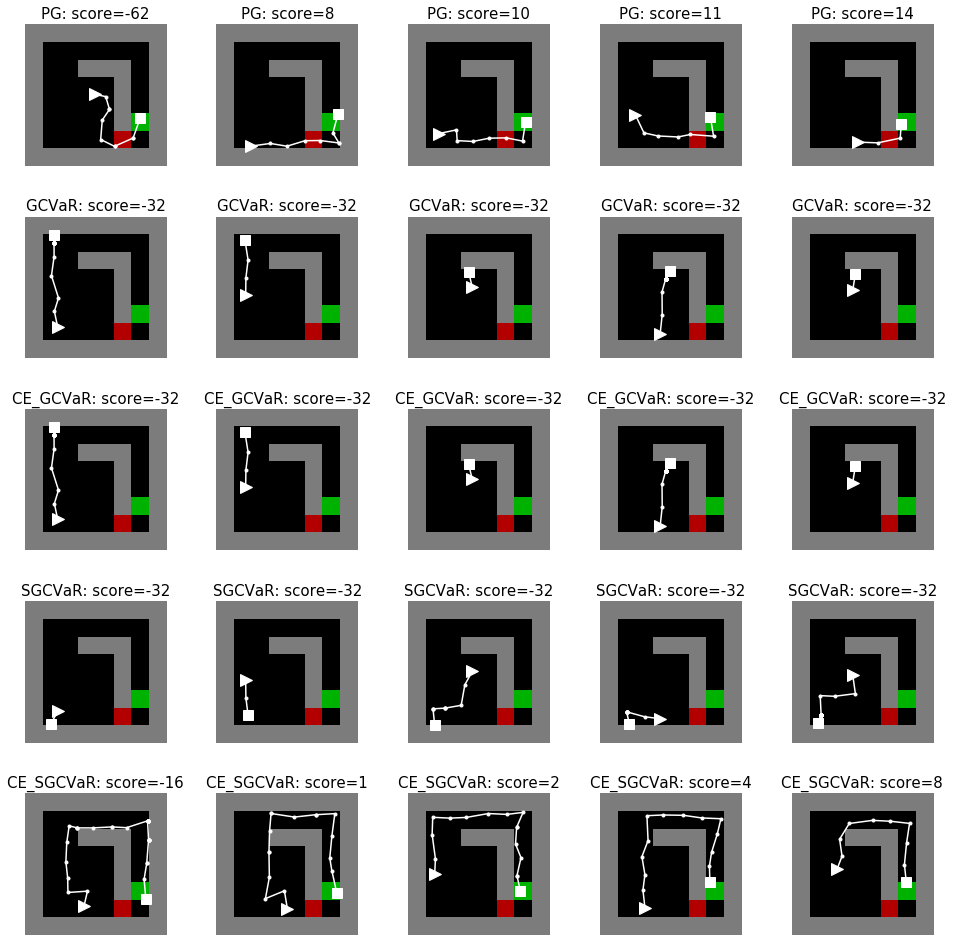

In [4]:
%%time

# Define agents (note that the training hyperparams are also defined here through the dict train_hparams).
agents = dict(
    PG = (Agents.FC, dict()),
    GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05))),
    CE_GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, ce_update_freq=1))),  # + CE
    SGCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, soft_cvar=0.7))),  # + soft-CVaR
    CE_SGCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.05, ce_update_freq=1, soft_cvar=0.7))),  # + CE + soft-CVaR
);

# Run experiment: setup, training, testing and analysis.
E1 = GML.Experiment(agents, train_episodes=60000, valid_episodes=60, test_episodes=1000,
                    guard_prob=0.05, rand_cost=False, optim_freq=400, title='maze_Beta05')
axs = E1.main()

# Save results and show a sample of episodes.
axs[2].legend(fontsize=13, loc='lower right')
plt.savefig('outputs/maze_Beta05_summary.png', bbox_inches='tight')
E1.save_results()
E1.show_tests()
plt.savefig('outputs/maze_Beta05_examples.png', bbox_inches='tight')
E1.dd